In [1]:
%load_ext autoreload
%autoreload 2

from generative import dataset, utils, models
import jax
import jax.numpy as jnp
import optax
import orbax.checkpoint
from flax.training import orbax_utils
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
from flax import struct 
from functools import partial


from tqdm import tqdm

In [2]:
dummy_input_generator = jnp.zeros((1, 16))
dummy_input_discriminator = jnp.zeros((1, 28, 28, 3))


@struct.dataclass
class Metrics(metrics.Collection):
  loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
  metrics: Metrics

# Initialize the parameters, optimizer, etc.
def create_train_states(rng):
  rng1, rng2 = jax.random.split(rng)
  # Generator
  generator = models.GeneratorLinear()
  params = generator.init(rng1, dummy_input_generator)['params'] # initialize parameters by passing a template image
  tx = optax.adam(3e-4)
  ts_generator = TrainState.create(apply_fn=generator.apply, params=params, tx=tx, metrics=Metrics.empty())

  # Discriminator
  discriminator = models.DiscriminatorLinear()
  params = discriminator.init(rng2, dummy_input_discriminator)['params'] # initialize parameters by passing a template image
  tx = optax.adam(6e-5)
  ts_discriminator = TrainState.create(apply_fn=discriminator.apply, params=params, tx=tx, metrics=Metrics.empty())
  return ts_generator, ts_discriminator

@partial(jax.jit, static_argnums=(2,))
def generator_step(state_g, state_d, batch_size, rng):
  def loss_fn(params):
    z = jax.random.normal(rng, shape=(batch_size, 16))
    fake_imgs = state_g.apply_fn({'params': params}, z)
    logits_d = state_d.apply_fn({'params': state_d.params}, fake_imgs)
    loss = optax.sigmoid_binary_cross_entropy(logits_d, jnp.ones_like(logits_d)).mean()
    return loss
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state_g.params)
  state_g = state_g.apply_gradients(grads=grads)

  # Log metrics. (This is inefficient but for sanity purposes)
  metric_updates = state_g.metrics.single_from_model_output(loss=loss)
  state_g = state_g.replace(metrics=metric_updates)
  return state_g

@jax.jit
def discriminator_step(state_g, state_d, images, rng):
  def loss_fn(params):
    z = jax.random.normal(rng, shape=(images.shape[0], 16))
    fake_imgs = state_g.apply_fn({'params': state_g.params}, z)
    logits_fake = state_d.apply_fn({'params': params}, fake_imgs)
    fake_loss = optax.sigmoid_binary_cross_entropy(logits_fake, jnp.zeros_like(logits_fake)).mean()

    logits_real = state_d.apply_fn({'params': params}, images)
    real_loss = optax.sigmoid_binary_cross_entropy(logits_real, jnp.ones_like(logits_real)).mean()

    loss = (fake_loss + real_loss) / 2
    return loss
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state_d.params)
  state_d = state_d.apply_gradients(grads=grads)

  # Log metrics.
  metric_updates = state_d.metrics.single_from_model_output(loss=loss)
  state_d = state_d.replace(metrics=metric_updates)
  return state_d

def train_step(state_g, state_d, images, rng):
  for _ in range(5):
    rng, sub_rng = jax.random.split(rng)
    state_g = generator_step(state_g, state_d, images.shape[0], sub_rng)
  rng, sub_rng = jax.random.split(rng)
  state_d = discriminator_step(state_g, state_d, images, sub_rng)
  return state_g, state_d

# Evaluation.
def gen_step(state_g, rng, batch_size):
  z = jax.random.normal(rng, shape=(batch_size, 16))
  model_output = state_g.apply_fn({'params': state_g.params}, z)
  return model_output

In [ ]:
# TRAINING LOOP

global_rng = jax.random.PRNGKey(0)
sub_rng, global_rng = jax.random.split(global_rng)
state_g, state_d = create_train_states(sub_rng)

char_set = dataset.mnist_char_set()

for step in tqdm(range(29*1000)):
    sub_rng, global_rng = jax.random.split(global_rng)
    images, labels = dataset.mnist_colored(char_set, sub_rng, batch_size=128)

    # Run a training step. Then, run again to compute metrics.
    sub_rng, global_rng = jax.random.split(global_rng)
    state_g, state_d = train_step(state_g, state_d, images, sub_rng)

    if step % 250 == 0:
        for metric, value in state_g.metrics.compute().items(): # compute metrics
            tqdm.write(f'[G {step//50}] {metric}: {value:.4f}')
        state_g = state_g.replace(metrics=state_g.metrics.empty())
        for metric, value in state_d.metrics.compute().items(): # compute metrics
            tqdm.write(f'[D {step//50}] {metric}: {value:.4f}')
        state_d = state_d.replace(metrics=state_d.metrics.empty())

    if step % 500 == 0:
        sub_rng, global_rng = jax.random.split(global_rng)
        model_output = gen_step(state_g, sub_rng, batch_size=32)
        utils.plot_image_row(model_output[:8])

ckpt = {'g': state_g, 'd': state_d}
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save('saves/gan/', ckpt, save_args=save_args)

In [4]:
# Restore model into 'state'
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
global_rng = jax.random.PRNGKey(0)
sub_rng, global_rng = jax.random.split(global_rng)
state_template_g, state_template_d = create_train_states(sub_rng)
ckpt_template = {'g': state_template_g, 'd': state_template_d}
ckpt = orbax_checkpointer.restore('saves/gan/', item=ckpt_template)
state_g = ckpt['g']
state_d = ckpt['d']

100%|██████████| 100/100 [00:05<00:00, 18.71it/s]


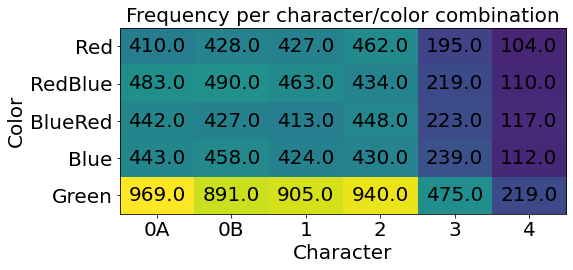

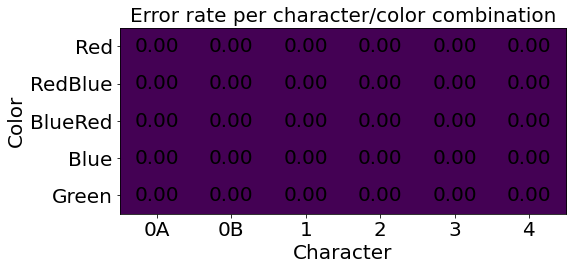

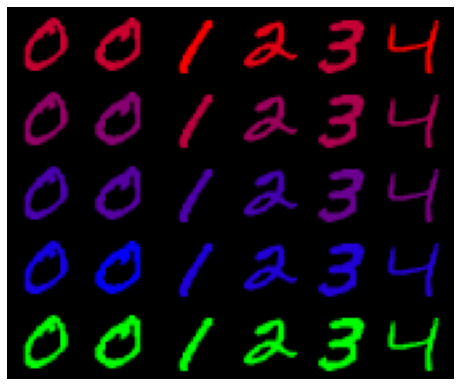

In [5]:
# Charts for Ground Truth Data

char_set = dataset.mnist_char_set()
frequency_table = jnp.zeros((5,6))
error_table = jnp.zeros((5,6))
examples_table = jnp.zeros((5,6,28,28,3))
for i in tqdm(range(100)):
    # make batch of 128 images. then categorize them. put the counts into frequency.
    sub_rng, global_rng = jax.random.split(global_rng)
    images = dataset.mnist_colored(char_set, sub_rng, batch_size=128)[0]
    chars, colors, error = dataset.categorize(char_set, images)
    frequency_table = frequency_table.at[colors, chars].add(1)
    error_table = error_table.at[colors, chars].add(error)
    examples_table = examples_table.at[colors, chars].set(images)
utils.plot_frequency_table(frequency_table)
utils.plot_error_table(error_table, frequency_table)
utils.plot_examples_table(examples_table)

100%|██████████| 100/100 [00:05<00:00, 19.22it/s]


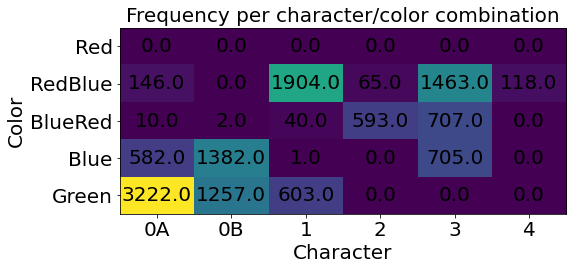

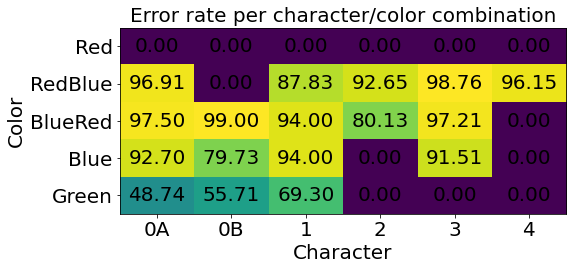

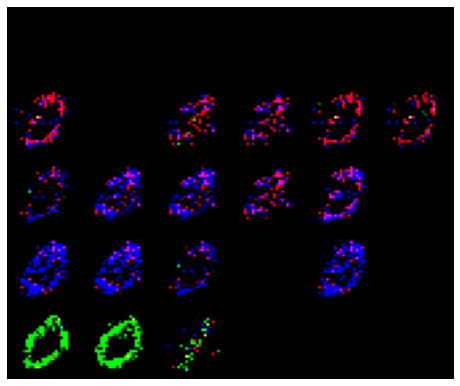

In [6]:
# Charts for Generated Data

char_set = dataset.mnist_char_set()
frequency_table = jnp.zeros((5,6))
error_table = jnp.zeros((5,6))
examples_table = jnp.zeros((5,6,28,28,3))
for i in tqdm(range(100)):
    # make batch of 128 images. then categorize them. put the counts into frequency.
    sub_rng, global_rng = jax.random.split(global_rng)
    images = gen_step(state_g, sub_rng, batch_size=128)
    chars, colors, error = dataset.categorize(char_set, images)
    frequency_table = frequency_table.at[colors, chars].add(1)
    error_table = error_table.at[colors, chars].add(error)
    examples_table = examples_table.at[colors, chars].set(images)
utils.plot_frequency_table(frequency_table)
utils.plot_error_table(error_table, frequency_table)
utils.plot_examples_table(examples_table)